In [ ]:
# Reproducible Analysis

## CASA0013: Foundations of Spatial Data Science

### Student Ids: ucfnlui, ucftYYYY, etc.

In [ ]:
### ucfnlui code:

In [1]:
print("start from here")

start from here


In [ ]:
### ucfniul code:

In [ ]:
print("start from here")

In [ ]:
### ucfnply code:

In [ ]:
print("start from here")

In [ ]:
### ucfnjin code:

In [1]:
print("start from here")

start from here


In [2]:
import csv
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [44]:
# read in data listings
data = pd.read_csv("http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/visualisations/listings.csv")
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,106332,"Lovely large room, Bethnal Green",264345,Susie,NaN,Tower Hamlets,51.52874,-0.05396,Private room,55,3,65,2016-06-10,0.47,1,74,0,NaN
1,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56861,-0.11270,Private room,50,1,30,2022-07-15,0.20,2,343,9,NaN
2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,1481412,Luca,NaN,Tower Hamlets,51.52851,-0.07426,Entire home/apt,90,5,42,2022-01-04,0.34,1,222,1,NaN
3,107048,A Luxury Studio Suite in Clerkenwell,259088,Simon,NaN,Islington,51.52478,-0.10484,Private room,180,4,493,2022-09-02,3.59,5,236,20,NaN
4,284603,Notting Hill church stay in Heaven!,1481851,Tania,NaN,Kensington and Chelsea,51.51464,-0.20004,Entire home/apt,297,14,6,2022-07-04,0.05,1,180,2,NaN


In [45]:
data.set_index('id',inplace = True)
#print data.head()

In [46]:
# read in data of London Boroughs
london = gpd.read_file("http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/visualisations/neighbourhoods.geojson", drivers='GPKG')

In [47]:
# check the crs of London Boroughs
print(london.crs)

epsg:4326


In [48]:
# transfer the crs of London Boroughs
london = london.to_crs('epsg:27700')

<AxesSubplot:>

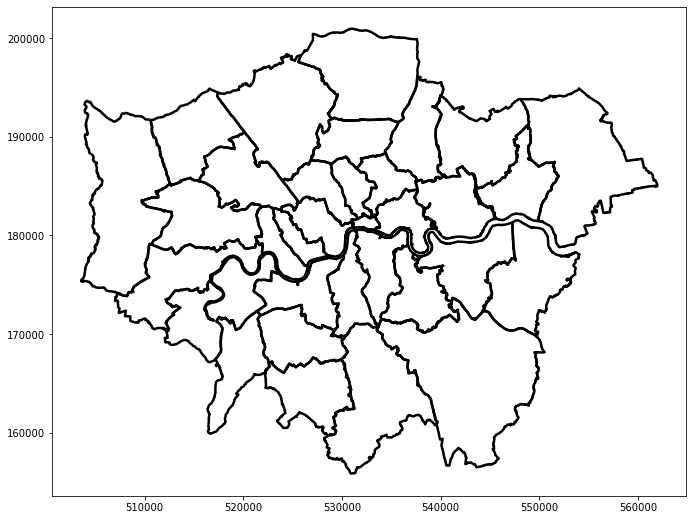

In [53]:
# plot London Boroughs with specified number ofsubplots and specified size
fig, ax = plt.subplots(1,1, figsize=(12,9))
london.plot(edgecolor="black", facecolor='none', linewidth=2.5, ax=ax)

In [54]:
# longitude and latitude to geoseries
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['longitude'],
                                                         data['latitude'],crs='epsg:4326'))

In [55]:
print(type(gdf))
print(type(gdf.geometry))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>


In [56]:
# converted data to a GeoDataFrame
gdf = gdf.to_crs('epsg:27700')
print(gdf.geometry.crs)
print(gdf.total_bounds)

epsg:27700
[502615.87511762 154633.50599878 560027.49389306 202832.88761803]


<AxesSubplot:>

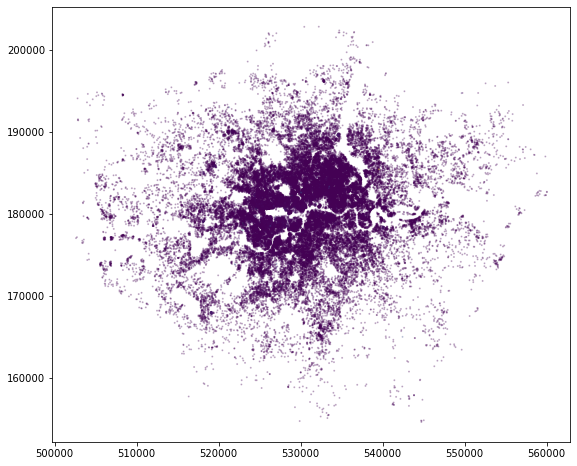

In [57]:
# a quick check
gdf.plot(column='price', cmap='viridis', alpha=0.25, markersize=1, figsize=(12,8))

In [58]:
# review of the range and other basic info of listings' price
print(f"The range of price is ${gdf.price.min():,.2f} to ${gdf.price.max():,.2f}")
print(f"The mean and median of the price are ${gdf.price.mean():,.2f} and ${gdf.price.median():,.2f}")

The range of price is $0.00 to $25,000.00
The mean and median of the price are $177.21 and $100.00


In [59]:
# read in the data of attractions
attractions = gpd.read_file("ucfnjin data/attractions.gpkg",drivers = 'GPKG')

In [60]:
# check crs
print(attractions.crs)

epsg:4326


In [61]:
# convert crs
attractions = attractions.to_crs('epsg:27700')

<AxesSubplot:>

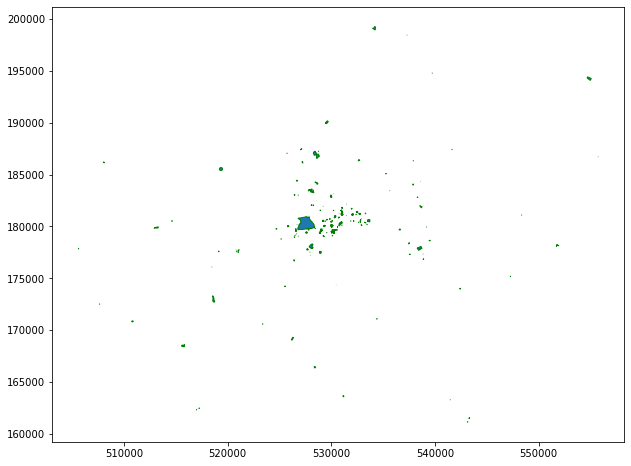

In [74]:
# a quick check
attractions.plot(edgecolor = "green", figsize=(12,8))

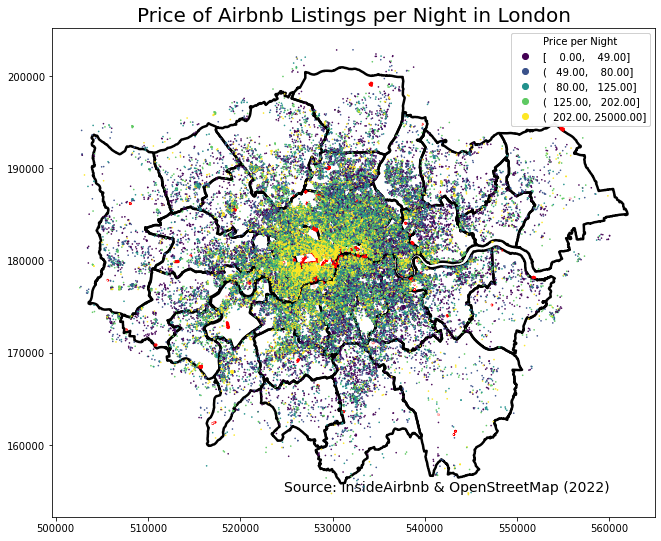

In [87]:
# join all together
import pysal as p
import mapclassify as mc
import palettable.matplotlib as palmpl
from legendgram import legendgram

# use Mapclassify to calculate quantiles (k=5) using the original price
q = mc.Quantiles(gdf.price.values, k=5)

# write binned values back to dataframe and use them with the GDF plot function
gdf['bins'] = q.yb

# map
fig,ax = plt.subplots(figsize=(15,9))
london.plot(edgecolor= "black", facecolor='none', linewidth=2.5, zorder=3, ax=ax)
attractions.plot(edgecolor= "red", facecolor='none', linewidth=2.5, zorder=3, ax=ax)

# "categorical=T" here means plot binned values with a categorical legend instead of the price using a continuous legend
gdf.plot(column='bins', categorical=True, cmap='viridis', 
         legend=True, marker='.', markersize=1.5, zorder=4, ax=ax)

# set title
ax.set_title('Price of Airbnb Listings per Night in London', 
             fontdict={'fontsize':'20', 'fontweight':'3'})

# create the legend 
# loop through each layer - patch collections to look for the z-order of collection equals to 4
for c in ax.collections:
    if c.get_zorder()==4:
        handles, _ = c.legend_elements(prop="colors")
        legend = ax.legend(handles, q.get_legend_classes(fmt='{:.2f}'), 
                            loc="upper right", title="Price per Night", 
                            prop={'size':'10', 'weight':'1'})
        ax.add_artist(legend)

# add a souce in the corner
a = ax.text(gdf.geometry.x.max(), gdf.geometry.y.min(), 'Source: InsideAirbnb & OpenStreetMap (2022)', 
            horizontalalignment='right', verticalalignment='bottom', fontsize=14, fontweight=4)

plt.savefig('Price-of-Airbnb-Listings-per-Night-in-London.png', dpi=150)

<AxesSubplot:>

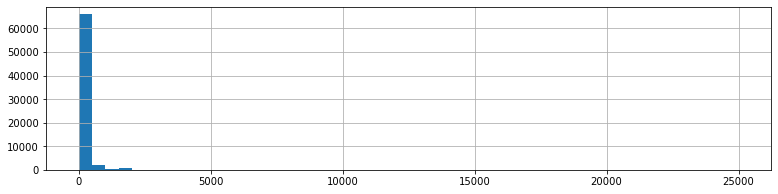

In [81]:
gdf.price.hist(bins=50, figsize=(13,3))